# Using and setting up easyfsl

In [ ]:
!pip install easyfsl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pathlib import Path
import random
from statistics import mean

import numpy as np
import torch
from torch import nn
from tqdm import tqdm

## Setting seed

In [ ]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading Dataset

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision import transforms

batch_size = 16
n_workers = 2
image_size = 128
train_set = Flowers102(
    root="./data",
    split = 'train',
    transform=transforms.Compose(
        [
            transforms.Resize((image_size,image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ]
    ),
    download=True,
)

In [ ]:
n_tasks_per_epoch = 100
train_sampler = TaskSampler(
    train_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_tasks_per_epoch
)

train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [ ]:
print(f'Length of train dataset: {len(train_set)}')

Length of train dataset: 1020


# Classical training

## Transfer learning with resnet12

In [ ]:
train_set.get_labels = lambda: [
    instance[1] for instance in train_set
]

In [ ]:
print(f"Num of flower classes: {len(set(train_set.get_labels()))}")

Num of flower classes: 102


In [ ]:
from easyfsl.modules import resnet18

DEVICE = "cuda"

model = resnet18(
    use_fc=True,
    num_classes=102,
).to(DEVICE)

## Task sampling

In [ ]:
from easyfsl.methods import PrototypicalNetworks
from easyfsl.samplers import TaskSampler
n_way = 5
n_shot = 4
n_query = 6
n_validation_tasks = 100

val_set = Flowers102(
    root="./data",
    split = 'val',
    transform=transforms.Compose(
        [
            transforms.Resize((image_size,image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ]
    ),
    download=True,
)

In [ ]:

val_set.get_labels = lambda: [
    instance[1] for instance in val_set
]
val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)

val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

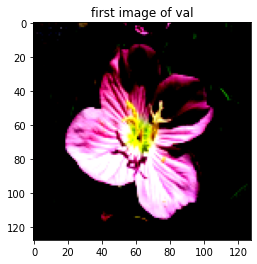

In [ ]:
from easyfsl.utils import plot_images
plot_images(val_set[0][0], "first image of val", 1)

# Episodic Training

In [ ]:
from easyfsl.modules import resnet18
from easyfsl.methods import FewShotClassifier
k = 10

In [ ]:
import torch
from torch import Tensor
from easyfsl.utils import compute_prototypes


class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )
       
        # Performing
        dists = torch.cdist(z_query, z_support)
        
        dists,indices = torch.sort(dists, dim = 1)
        
        dists = dists[:,:k]
        indices = indices [:,:k]
        mode_map = []
        
        for row in indices:
          mode_map.append([0 for i in range(n_way)])
          for j in row:
            mode_map[-1][support_labels[j]]+=1
        mode_map = torch.tensor(mode_map)
        
        x = (mode_map.float()).to(DEVICE)

        dists = torch.cdist(z_query, z_proto).to(DEVICE)
        delta = 1
        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -(dists/(x+delta))
    
        return scores


In [ ]:
DEVICE = "cuda"
convolutional_network = resnet18()
few_shot_classifier = PrototypicalNetworks(convolutional_network).to(DEVICE)

### Episodic Training

In [ ]:
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter


LOSS_FUNCTION = nn.CrossEntropyLoss()

n_epochs = 30
scheduler_milestones = [120, 160]
scheduler_gamma = 0.1
learning_rate = 1e-2
tb_logs_dir = Path(".")

train_optimizer = SGD(
    few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
)
train_scheduler = MultiStepLR(
    train_optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)

tb_writer = SummaryWriter(log_dir=str(tb_logs_dir))

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
    model
) :
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.to(DEVICE), support_labels.to(DEVICE), query_images.to(DEVICE))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(DEVICE)
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader, model):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels,model
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )
    return (100 * correct_predictions/total_predictions)



In [ ]:
def training_epoch(
    model: FewShotClassifier, data_loader: DataLoader, optimizer: Optimizer
):
    all_loss = []
    model.train()
    with tqdm(
        enumerate(data_loader), total=len(data_loader), desc="Training"
    ) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            _,
        ) in tqdm_train:
            optimizer.zero_grad()
            
            classification_scores = model(
        support_images.to(DEVICE), support_labels.to(DEVICE), query_images.to(DEVICE)
    )

            loss = LOSS_FUNCTION(classification_scores, query_labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

In [ ]:
evaluate(val_loader, few_shot_classifier)

100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 39.60%


39.6

In [ ]:



best_state = few_shot_classifier.state_dict()
best_validation_accuracy = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
   
    average_loss = training_epoch(few_shot_classifier, train_loader, train_optimizer)
    train_accuracy = evaluate(train_loader,few_shot_classifier)
    validation_accuracy = evaluate(val_loader,few_shot_classifier)
    

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = few_shot_classifier.state_dict()
        print("We found a new best model!")

    tb_writer.add_scalar("Train/loss", average_loss, epoch)
    tb_writer.add_scalar("Train/acc", train_accuracy, epoch)
    tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)
    
    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    train_scheduler.step()

Epoch 0


100%|██████████| 100/100 [00:36<00:00,  2.77it/s]

Model tested on 100 tasks. Accuracy: 56.33%



100%|██████████| 100/100 [00:35<00:00,  2.79it/s]

Model tested on 100 tasks. Accuracy: 58.23%
We found a new best model!
Epoch 1



100%|██████████| 100/100 [00:36<00:00,  2.76it/s]

Model tested on 100 tasks. Accuracy: 60.40%



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 61.53%
We found a new best model!
Epoch 2



100%|██████████| 100/100 [00:35<00:00,  2.79it/s]

Model tested on 100 tasks. Accuracy: 60.53%



100%|██████████| 100/100 [00:35<00:00,  2.81it/s]

Model tested on 100 tasks. Accuracy: 58.77%
Epoch 3



100%|██████████| 100/100 [00:36<00:00,  2.75it/s]

Model tested on 100 tasks. Accuracy: 63.37%



100%|██████████| 100/100 [00:35<00:00,  2.82it/s]

Model tested on 100 tasks. Accuracy: 60.80%
Epoch 4



100%|██████████| 100/100 [00:36<00:00,  2.77it/s]

Model tested on 100 tasks. Accuracy: 64.30%



100%|██████████| 100/100 [00:35<00:00,  2.79it/s]

Model tested on 100 tasks. Accuracy: 60.07%
Epoch 5



100%|██████████| 100/100 [00:36<00:00,  2.76it/s]

Model tested on 100 tasks. Accuracy: 64.03%



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 65.70%
We found a new best model!
Epoch 6



100%|██████████| 100/100 [00:36<00:00,  2.77it/s]

Model tested on 100 tasks. Accuracy: 65.37%



100%|██████████| 100/100 [00:35<00:00,  2.78it/s]

Model tested on 100 tasks. Accuracy: 63.80%
Epoch 7



100%|██████████| 100/100 [00:35<00:00,  2.79it/s]

Model tested on 100 tasks. Accuracy: 67.67%



100%|██████████| 100/100 [00:35<00:00,  2.79it/s]

Model tested on 100 tasks. Accuracy: 63.60%
Epoch 8



100%|██████████| 100/100 [00:36<00:00,  2.77it/s]

Model tested on 100 tasks. Accuracy: 67.00%



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 61.83%
Epoch 9



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 70.43%



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 64.67%
Epoch 10



100%|██████████| 100/100 [00:35<00:00,  2.82it/s]

Model tested on 100 tasks. Accuracy: 67.40%



100%|██████████| 100/100 [00:36<00:00,  2.77it/s]

Model tested on 100 tasks. Accuracy: 62.90%
Epoch 11



100%|██████████| 100/100 [00:35<00:00,  2.79it/s]

Model tested on 100 tasks. Accuracy: 71.77%



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 67.10%
We found a new best model!
Epoch 12



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 71.73%



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 65.77%
Epoch 13



100%|██████████| 100/100 [00:36<00:00,  2.76it/s]

Model tested on 100 tasks. Accuracy: 72.70%



100%|██████████| 100/100 [00:36<00:00,  2.77it/s]

Model tested on 100 tasks. Accuracy: 69.17%
We found a new best model!
Epoch 14



100%|██████████| 100/100 [00:36<00:00,  2.77it/s]

Model tested on 100 tasks. Accuracy: 72.23%



100%|██████████| 100/100 [00:35<00:00,  2.78it/s]

Model tested on 100 tasks. Accuracy: 65.77%
Epoch 15



100%|██████████| 100/100 [00:36<00:00,  2.76it/s]

Model tested on 100 tasks. Accuracy: 73.53%



100%|██████████| 100/100 [00:35<00:00,  2.81it/s]

Model tested on 100 tasks. Accuracy: 67.27%
Epoch 16



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 74.90%



100%|██████████| 100/100 [00:35<00:00,  2.78it/s]

Model tested on 100 tasks. Accuracy: 69.47%
We found a new best model!
Epoch 17



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 76.23%



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 69.77%
We found a new best model!
Epoch 18



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 74.93%



100%|██████████| 100/100 [00:36<00:00,  2.77it/s]

Model tested on 100 tasks. Accuracy: 69.17%
Epoch 19



100%|██████████| 100/100 [00:36<00:00,  2.76it/s]

Model tested on 100 tasks. Accuracy: 76.57%



100%|██████████| 100/100 [00:35<00:00,  2.78it/s]

Model tested on 100 tasks. Accuracy: 69.33%
Epoch 20



100%|██████████| 100/100 [00:36<00:00,  2.78it/s]

Model tested on 100 tasks. Accuracy: 75.97%



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 69.27%
Epoch 21



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 79.40%



100%|██████████| 100/100 [00:35<00:00,  2.81it/s]

Model tested on 100 tasks. Accuracy: 70.83%
We found a new best model!
Epoch 22



100%|██████████| 100/100 [00:35<00:00,  2.81it/s]

Model tested on 100 tasks. Accuracy: 79.23%



100%|██████████| 100/100 [00:35<00:00,  2.79it/s]

Model tested on 100 tasks. Accuracy: 70.27%
Epoch 23



100%|██████████| 100/100 [00:35<00:00,  2.81it/s]

Model tested on 100 tasks. Accuracy: 77.43%



100%|██████████| 100/100 [00:35<00:00,  2.83it/s]

Model tested on 100 tasks. Accuracy: 71.10%
We found a new best model!
Epoch 24



100%|██████████| 100/100 [00:35<00:00,  2.82it/s]

Model tested on 100 tasks. Accuracy: 78.83%



100%|██████████| 100/100 [00:35<00:00,  2.82it/s]

Model tested on 100 tasks. Accuracy: 71.13%
We found a new best model!
Epoch 25



100%|██████████| 100/100 [00:36<00:00,  2.77it/s]

Model tested on 100 tasks. Accuracy: 79.87%



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 71.33%
We found a new best model!
Epoch 26



100%|██████████| 100/100 [00:35<00:00,  2.79it/s]

Model tested on 100 tasks. Accuracy: 78.23%



100%|██████████| 100/100 [00:35<00:00,  2.79it/s]

Model tested on 100 tasks. Accuracy: 71.23%
Epoch 27



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 79.63%



100%|██████████| 100/100 [00:35<00:00,  2.82it/s]

Model tested on 100 tasks. Accuracy: 67.33%
Epoch 28



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 79.10%



100%|██████████| 100/100 [00:35<00:00,  2.79it/s]

Model tested on 100 tasks. Accuracy: 71.63%
We found a new best model!
Epoch 29



100%|██████████| 100/100 [00:35<00:00,  2.82it/s]

Model tested on 100 tasks. Accuracy: 80.53%



100%|██████████| 100/100 [00:35<00:00,  2.80it/s]

Model tested on 100 tasks. Accuracy: 71.87%
We found a new best model!


In [ ]:
few_shot_classifier.load_state_dict(best_state)

<All keys matched successfully>

In [ ]:
n_way = 5
n_shot = 4
n_query = 6
n_test_tasks = 200

test_set = Flowers102(
    root="./data",
    split = 'test',
    transform=transforms.Compose(
        [
            transforms.RandomResizedCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
        ]
    ),
    download=True,
)
test_set.get_labels = lambda: [
    instance[1] for instance in test_set
]
test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks= n_test_tasks
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)


In [ ]:
evaluate(test_loader,few_shot_classifier)

100%|██████████| 200/200 [01:05<00:00,  3.03it/s]

Model tested on 200 tasks. Accuracy: 66.12%


66.11666666666666